#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid')

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    n_samples = len(y)
    linear_combination = y * (np.dot(X, w) + w0)

    # Вычисляем значение функции потерь
    loss_value = (1 / n_samples) * np.sum(np.log(1 + np.exp(-linear_combination)))

    l1_penalty = gamma * np.sum(np.abs(w))
    l2_penalty = beta * np.sum(w ** 2)

    total_loss = loss_value + l1_penalty + l2_penalty
    return total_loss


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[np.ndarray, float]:
    num_samples = len(y)
    linear_combination = y * (np.dot(X, w) + w0)

    # Вычисляем градиенты
    exp_term = np.exp(linear_combination)
    grad_weights = (-1 / num_samples) * (np.dot(X.T, y / (1 + exp_term))) + gamma * np.sign(w) + 2 * beta * w
    grad_bias = (-1 / num_samples) * np.sum(y / (1 + exp_term))

    return np.array(grad_weights), grad_bias



In [5]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, learning_rate=1e-2, convergence_threshold=1e-8, max_iterations=1000, seed=42):
        self.beta = beta
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.convergence_threshold = convergence_threshold
        self.max_iterations = max_iterations
        self.seed = seed
        self.weights = None
        self.intercept = None
        self.loss_values = []

    def fit(self, X, y):
        y_transformed = 2 * y - 1
        np.random.seed(self.seed)
        self.weights = np.zeros(X.shape[1])
        self.intercept = 0.0

        for iteration in range(self.max_iterations):
            gradients_weights, gradients_intercept = get_grad(X, y_transformed, self.weights, self.intercept, gamma=self.gamma, beta=self.beta)

            # Обновление весов и перехвата
            self.weights -= self.learning_rate * gradients_weights
            self.intercept -= self.learning_rate * gradients_intercept

            current_loss_value = loss(X, y_transformed, self.weights, self.intercept, gamma=self.gamma, beta=self.beta)
            self.loss_values.append(current_loss_value)

            if np.linalg.norm(gradients_weights) < self.convergence_threshold:
                break
        return self

    def predict_proba(self, X):
        linear_output = np.dot(X, self.weights) + self.intercept
        probabilities = np.clip(1 / (1 + np.exp(-linear_output)), 1e-15, 1 - 1e-15)
        return np.vstack([1 - probabilities, probabilities]).T

    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities >= 0.5).astype(int)



In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    # Определяем границы графика
    x_min = X[:, 0].min() - 1
    x_max = X[:, 0].max() + 1
    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1

    # Создаем сетку для визуализации
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                   np.arange(y_min, y_max, 0.1))

    # Предсказываем метки на сетке
    predictions = model.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
    predictions = predictions.reshape(grid_x.shape)

    # Отображаем разделяющую гиперплоскость
    plt.contourf(grid_x, grid_y, predictions, alpha=0.3, cmap="coolwarm")

    # Отображаем объекты данных
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k', cmap="coolwarm")

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()




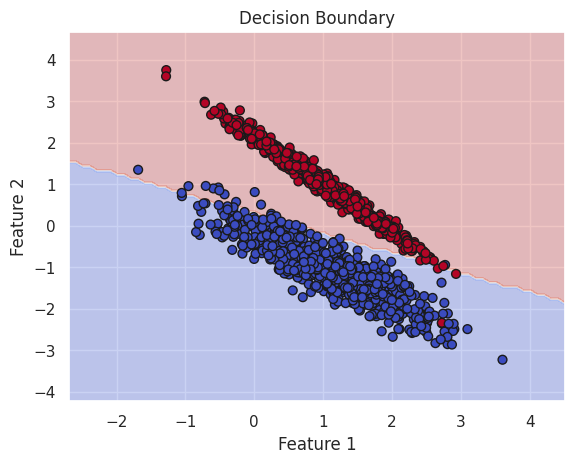

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)


#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    plt.figure(figsize=(10, 6))

    # Отображаем историю значений функции потерь
    plt.plot(model.loss_values, marker='o', color='blue', linestyle='-', markersize=5)

    plt.title("Loss Function History")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()



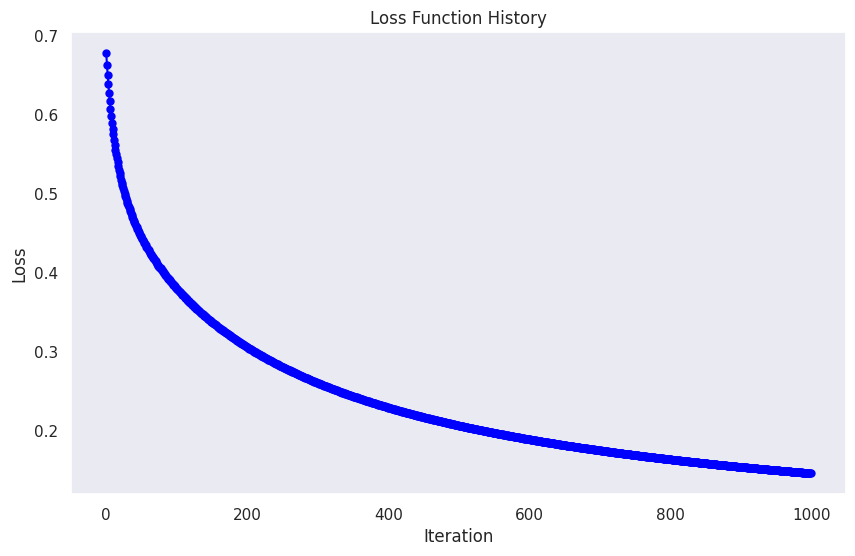

In [11]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Генерация синтетического набора данных
X_data, y_data = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                                      random_state=42, n_clusters_per_class=1)

# Разделение данных на обучающую и тестовую выборки
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Определяем ядра и значения C для SVC
kernel_types = ['linear', 'poly', 'rbf', 'sigmoid']
C_parameters = [0.1, 1, 10, 100]

# Обучение и оценка модели SVC
for kernel in kernel_types:
    for C in C_parameters:
        svc_model = SVC(kernel=kernel, C=C, probability=True)
        svc_model.fit(X_train_set, y_train_set)

        # Предсказания и вероятности
        y_predicted = svc_model.predict(X_test_set)
        y_probabilities = svc_model.predict_proba(X_test_set)[:, 1]

        # Метрики
        accuracy = accuracy_score(y_test_set, y_predicted)
        precision = precision_score(y_test_set, y_predicted)
        recall = recall_score(y_test_set, y_predicted)
        auc_roc = roc_auc_score(y_test_set, y_probabilities)
        f1 = f1_score(y_test_set, y_predicted)

        # Вывод результатов
        print(f"Kernel: {kernel}, C: {C}")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC-ROC: {auc_roc:.4f}, F1-Score: {f1:.4f}")
        print("-" * 50)


Kernel: linear, C: 0.1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9998, F1-Score: 0.9971
--------------------------------------------------
Kernel: linear, C: 1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9994, F1-Score: 0.9971
--------------------------------------------------
Kernel: linear, C: 10
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9988, F1-Score: 0.9971
--------------------------------------------------
Kernel: linear, C: 100
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9988, F1-Score: 0.9971
--------------------------------------------------
Kernel: poly, C: 0.1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9963, F1-Score: 0.9971
--------------------------------------------------
Kernel: poly, C: 1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9977, F1-Score: 0.9971
--------------------------------------------------
Kernel: poly, C: 10
Accuracy: 0.9972, Preci

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [13]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise_distances

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, distance_metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.distance_metric = distance_metric
        self.X_train_data = None
        self.y_train_data = None

    def fit(self, X, y):
        self.X_train_data = X
        self.y_train_data = y
        return self

    def predict(self, X):
        # Вычисляем расстояния между тестовыми и обучающими данными
        distances = pairwise_distances(X, self.X_train_data, metric=self.distance_metric)
        # Находим индексы k ближайших соседей
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train_data[nearest_indices]

        # Получаем предсказания
        predictions = []
        for labels in nearest_labels:
            unique_labels, counts = np.unique(labels, return_counts=True)
            predicted_label = unique_labels[np.argmax(counts)]
            predictions.append(predicted_label)

        return np.array(predictions)

    def predict_proba(self, X):
        # Вычисляем расстояния между тестовыми и обучающими данными
        distances = pairwise_distances(X, self.X_train_data, metric=self.distance_metric)
        # Находим индексы k ближайших соседей
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train_data[nearest_indices]

        # Вычисляем вероятности для каждого класса
        probabilities = []
        for labels in nearest_labels:
            unique_labels, counts = np.unique(labels, return_counts=True)
            prob_distribution = np.zeros(np.max(self.y_train_data) + 1)  # Инициализируем вектор вероятностей
            prob_distribution[unique_labels] = counts / self.n_neighbors  # Заполняем вероятности
            probabilities.append(prob_distribution)

        return np.array(probabilities)




In [14]:
# Тестирование KNNClassifier на данных
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Генерация синтетического набора данных
X_data, y_data = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                                      random_state=42, n_clusters_per_class=1)

# Разделение данных на обучающую и тестовую выборки
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Создание и обучение модели KNN
knn_model = KNNClassifier(n_neighbors=5)
knn_model.fit(X_train_set, y_train_set)

# Предсказания и вероятности
y_predicted = knn_model.predict(X_test_set)
y_probabilities = knn_model.predict_proba(X_test_set)[:, 1]

# Метрики
accuracy = accuracy_score(y_test_set, y_predicted)
precision = precision_score(y_test_set, y_predicted)
recall = recall_score(y_test_set, y_predicted)
roc_auc = roc_auc_score(y_test_set, y_probabilities)
f1 = f1_score(y_test_set, y_predicted)

# Вывод результатов
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC-ROC: {roc_auc:.4f}, F1-Score: {f1:.4f}")

Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9973, F1-Score: 0.9971


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [15]:
import pandas as pd

data = pd.read_csv('train.csv')

print(data.head())

train_data = data[:50000]
test_data = data[50000:]

# Извлекаем признаки и метки
X_train = train_data.drop(columns=['Id', 'Category'])
y_train = train_data['Category']

X_test = test_data.drop(columns=['Id', 'Category'])
y_test = test_data['Category']

# Выводим размеры выборок
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

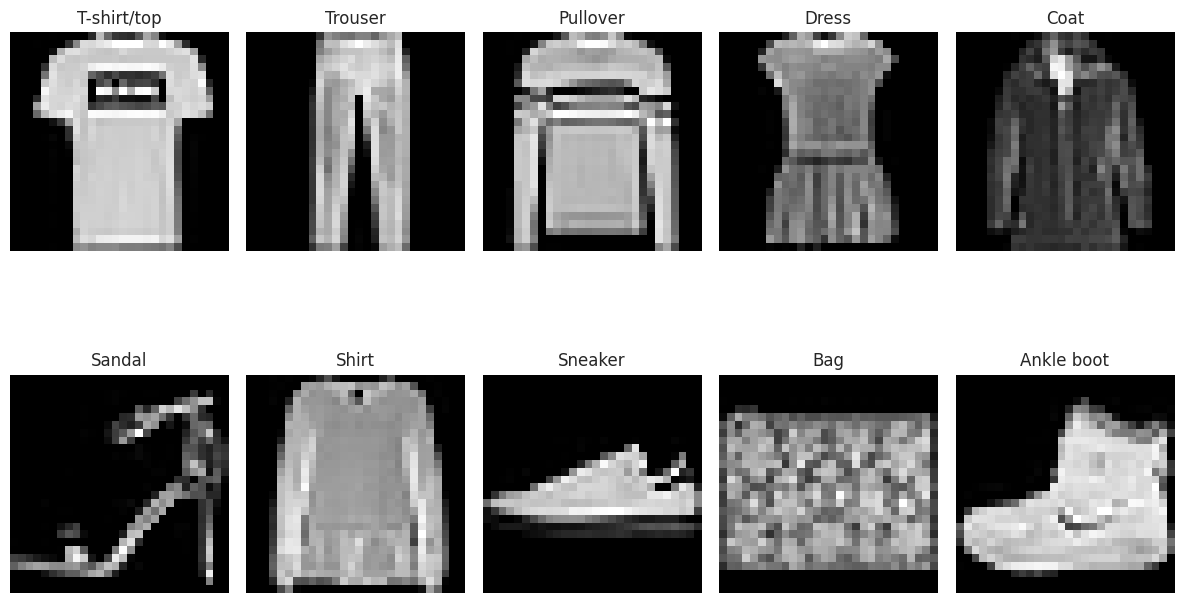

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Загружаем датасет Fashion MNIST
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
images = fashion_mnist.data.values.reshape(-1, 28, 28)
labels = fashion_mnist.target.astype(int)

# Определяем названия классов
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Создаем график для визуализации
plt.figure(figsize=(12, 8))
for i in range(10):
    image = images[labels == i][0]

    # Строим подграфик
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image, cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [17]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загружаем датасет Fashion MNIST
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
images = fashion_mnist.data.values.reshape(-1, 28, 28)
labels = fashion_mnist.target.astype(int)

# Преобразуем изображения в двумерный массив
images_flattened = images.reshape(-1, 28 * 28)

# Нормализация с помощью StandardScaler
scaler_standard = StandardScaler()
images_scaled_standard = scaler_standard.fit_transform(images_flattened)

# Нормализация с помощью MinMaxScaler
scaler_minmax = MinMaxScaler()
images_scaled_minmax = scaler_minmax.fit_transform(images_flattened)

# Выводим статистику для обоих методов нормализации
print("Statistics after StandardScaler")
print("Minimum:", np.min(images_scaled_standard), "Maximum:", np.max(images_scaled_standard))

print("Statistics after MinMaxScaler")
print("Minimum:", np.min(images_scaled_minmax), "Maximum:", np.max(images_scaled_minmax))


Statistics after StandardScaler
Minimum: -2.4115701151932663 Maximum: 194.09155051552787
Statistics after MinMaxScaler
Minimum: 0.0 Maximum: 1.0


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных для улучшения качества модели
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметры для KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

# Параметры для логистической регрессии
logreg_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Инициализация классификаторов
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression()

# Настройка сетки поиска для KNN и логистической регрессии
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='accuracy')
logreg_grid = GridSearchCV(logreg_model, logreg_params, cv=5, scoring='accuracy')

# Обучение моделей с использованием сетки поиска
knn_grid.fit(X_train, y_train)
logreg_grid.fit(X_train_scaled, y_train)

# Получение лучших параметров и оценок моделей
knn_best_params = knn_grid.best_params_
knn_best_score = knn_grid.best_score_
logreg_best_params = logreg_grid.best_params_
logreg_best_score = logreg_grid.best_score_

# Обучение моделей с лучшими параметрами
best_knn = KNeighborsClassifier(**knn_best_params)
best_logreg = LogisticRegression(**logreg_best_params)

best_knn.fit(X_train, y_train)
best_logreg.fit(X_train_scaled, y_train)

# Предсказания на тестовой выборке
y_pred_knn = best_knn.predict(X_test)
y_pred_logreg = best_logreg.predict(X_test_scaled)

# Оценка точности моделей
knn_accuracy = accuracy_score(y_test, y_pred_knn)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

# Вывод результатов
print("KNeighborsClassifier")
print(f"Optimal hyperparameters: {knn_best_params}")
print(f"Cross-validated accuracy on training data: {knn_best_score:.4f}")
print(f"Accuracy on test data: {knn_accuracy:.4f}")

print("\nLogisticRegression")
print(f"Optimal hyperparameters: {logreg_best_params}")
print(f"Cross-validated accuracy on training data: {logreg_best_score:.4f}")
print(f"Accuracy on test data: {logreg_accuracy:.4f}")

if knn_accuracy > logreg_accuracy:
    print("\nKNeighborsClassifier shows superior accuracy.")
    print("This could be attributed to KNN's consideration of neighbor proximity, allowing for better class differentiation.")
elif knn_accuracy < logreg_accuracy:
    print("\nLogisticRegression shows superior accuracy.")
    print("Logistic regression may handle linearly separable data more effectively.")
else:
    print("\nBoth models provide the same accuracy.")



KNeighborsClassifier
Optimal hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7}
Cross-validated accuracy on training data: 0.9958
Accuracy on test data: 0.9972

LogisticRegression
Optimal hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Cross-validated accuracy on training data: 0.9958
Accuracy on test data: 0.9972

Both models provide the same accuracy.


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

При обучении логистической регрессии на датасете с 10,000 объектами, где 5,000 объектов принадлежат к отрицательному классу и 5,000 к положительному, с одинаковыми признаками для всех объектов, можно ожидать следующее:

**Данные:** у всех объектов одинаковые значения признаков, но они принадлежат к двум различным классам. Это создает ситуацию, когда логистическая регрессия не сможет эффективно разделить эти два класса, поскольку у нее нет информации, позволяющей отличать их друг от друга по признакам.

**Логистическая регрессия:** логистическая регрессия пытается найти границу между классами, основываясь на значениях признаков. В данном случае, так как все объекты имеют одинаковые значения признаков, алгоритм не сможет найти значимую зависимость между признаками и классами.

**Обучение модели:** при использовании стохастического градиентного спуска (SGD) для обновления весов, модель будет пытаться минимизировать функцию потерь, однако все веса будут стремиться к одной и той же константе. Таким образом, модель будет иметь одинаковое предсказание для всех объектов.

**Итоговые результаты:**

**Точность:** модель, скорее всего, будет предсказывать один из классов (либо положительный, либо отрицательный) для всех объектов. Это приведет к точности около 50%, если она будет предсказывать положительный класс для половины объектов, и отрицательный для остальных.

**Низкая качество модели:** модель не сможет научиться отличать классы, так как отсутствует информация для разделения. В результате, предсказания модели будут неэффективными, и она не будет удовлетворять критериям хорошей классификации.

**Вывод:**

В результате обучения логистической регрессии на этом датасете с использованием SGD, мы получим модель, которая предсказывает один класс для всех объектов, с точностью, близкой к 50%, что является неэффективным результатом для задачи классификации. Это объясняется тем, что отсутствуют различия в значениях признаков, позволяющих модели учиться и находить разделяющую границу.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

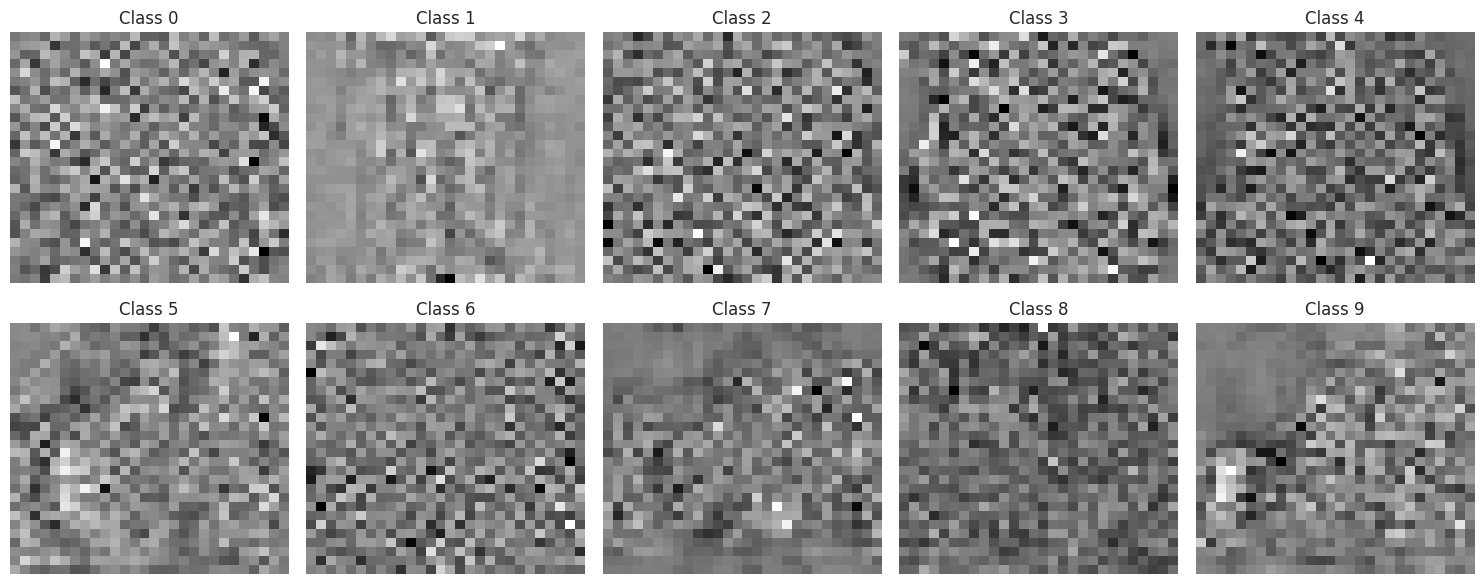

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier

# Загрузка данных Fashion MNIST
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
X = fashion_mnist.data.values
y = fashion_mnist.target.astype(int)

# Разделение выборки
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=10000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Обучение модели с использованием метода One-VS-Rest
classifier = OneVsRestClassifier(LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42))
classifier.fit(X_train_normalized, y_train)

# Извлечение весов классификаторов
model_weights = classifier.estimators_
num_classes = len(model_weights)

# Визуализация весов
fig, axes_arr = plt.subplots(2, 5, figsize=(15, 6))
axes_arr = axes_arr.flatten()

for index in range(num_classes):
    axes_arr[index].imshow(model_weights[index].coef_.reshape(28, 28), cmap='gray', aspect='auto')
    axes_arr[index].set_title(f'Class {index}')
    axes_arr[index].axis('off')

plt.tight_layout()
plt.show()


#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

# Загружаем данные
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
X = fashion_mnist.data
y = fashion_mnist.target.astype(int)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модели и их параметры
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
}
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

# Определяем модели
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svc = SVC(random_state=42)

# Подбор гиперпараметров для Random Forest
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

# Подбор гиперпараметров для Gradient Boosting
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)

# Подбор гиперпараметров для SVC
svc_grid = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy', n_jobs=-1)
svc_grid.fit(X_train_scaled, y_train)

# Получение лучших моделей
best_rf = rf_grid.best_estimator_
best_gb = gb_grid.best_estimator_
best_svc = svc_grid.best_estimator_

# Оценка на тестовой выборке
rf_pred = best_rf.predict(X_test_scaled)
gb_pred = best_gb.predict(X_test_scaled)
svc_pred = best_svc.predict(X_test_scaled)

# Вычисление точности
rf_accuracy = accuracy_score(y_test, rf_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)
svc_accuracy = accuracy_score(y_test, svc_pred)

# Вывод результатов
print("Random Forest Test Accuracy:", rf_accuracy)
print("Gradient Boosting Test Accuracy:", gb_accuracy)
print("SVC Test Accuracy:", svc_accuracy)

# Определение лучшей модели
accuracies = {
    "Random Forest": rf_accuracy,
    "Gradient Boosting": gb_accuracy,
    "SVC": svc_accuracy,
}

best_model = max(accuracies, key=accuracies.get)
print(f"\nBest model: {best_model} with accuracy: {accuracies[best_model]:.4f}")


KeyboardInterrupt: 